# TFM. Deep Visin applied to Real state.

https://docs.google.com/document/d/1z8G_THiNSHe14UcoJhIIcJL4NLlCuOiVTu6yvla37qo/edit#d


In [1]:
# google stuff
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


- libraries

In [3]:
%tensorflow_version 2.x
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# architecture 
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers
#from keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras import Model

# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# optimization
from tensorflow.keras.optimizers import Adam
from keras import regularizers
#from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, BatchNormalization, MaxPooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.regularizers import l1_l2, l2

# pre-trained models
#from tensorflow.keras.applications import VGG16, ResNet50, VGG19

import os
import pickle
import tarfile

# counting classes with library
from collections import Counter

# viz & arrays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

- base directory

In [4]:
!ls "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"

 AlbertoVargas-sistema_clasificacion_viviendas_imagenes.gslides   input    src
'Dudas y seguimiento TFM.gdoc'					  output


In [5]:
base_folder = "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"
input_folder = base_folder+"input/"
src_folder =  base_folder+"src/"
output_folder = base_folder + "/output/"

- functions

In [6]:
# insert the directory
import sys
sys.path.insert(0,"/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/src/")

In [7]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD#, Adam

from my_functions import freezing_layers, vgg16_19_conf, resnet50_conf, nn_parameters, plotting_model, generic_last_2layers
from datetime import datetime

# load pickling data allocated in Drive

In [58]:
with open(input_folder+"pickle_all_images_df.pickle", "rb") as input_file:
    data_x_norm= pickle.load(input_file) # camiado para desnormalizar para imaug
with open(input_folder+"pickle_all_classes.pickle", "rb") as input_file:
    data_y = pickle.load(input_file)

- data autmentation with **imaug**

In [59]:
# we have to undo the normalization to 0-1 in the picture
data_x_unnormalized= ((data_x_norm - data_x_norm.min()) * (1/(data_x_norm.max() - data_x_norm.min()) * 255)).astype('uint8')

In [60]:
#https://imgaug.readthedocs.io/en/latest/source/examples_basics.html#a-simple-and-common-augmentation-sequence
#import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
ia.seed(42)

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second
# image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image.
seq = iaa.Sequential(
    [
        #
        # Apply the following augmenters to most images.
        #
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images

        # crop some of the images by 0-10% of their height/width
        sometimes(iaa.Crop(percent=(0, 0.1))),

        # Apply affine transformations to some of the images
        # - scale to 80-120% of image height/width (each axis independently)
        # - translate by -20 to +20 relative to height/width (per axis)
        # - rotate by -45 to +45 degrees
        # - shear by -16 to +16 degrees
        # - order: use nearest neighbour or bilinear interpolation (fast)
        # - mode: use any available mode to fill newly created pixels
        #         see API or scikit-image for which modes are available
        # - cval: if the mode is constant, then use a random brightness
        #         for the newly created pixels (e.g. sometimes black,
        #         sometimes white)
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-45, 45),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),

        #
        # Execute 0 to 5 of the following (less important) augmenters per
        # image. Don't execute all of them, as that would often be way too
        # strong.
        #
        iaa.SomeOf((0, 5),
            [
                # Convert some images into their superpixel representation,
                # sample between 20 and 200 superpixels per image, but do
                # not replace all superpixels with their average, only
                # some of them (p_replace).
                sometimes(
                    iaa.Superpixels(
                        p_replace=(0, 1.0),
                        n_segments=(20, 200)
                    )
                ),

                # Blur each image with varying strength using
                # gaussian blur (sigma between 0 and 3.0),
                # average/uniform blur (kernel size between 2x2 and 7x7)
                # median blur (kernel size between 3x3 and 11x11).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),

                # Sharpen each image, overlay the result with the original
                # image using an alpha between 0 (no sharpening) and 1
                # (full sharpening effect).
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

                # Same as sharpen, but for an embossing effect.
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),

                # Search in some images either for all edges or for
                # directed edges. These edges are then marked in a black
                # and white image and overlayed with the original image
                # using an alpha of 0 to 0.7.
                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.7)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0, 0.7), direction=(0.0, 1.0)
                    ),
                ])),

                # Add gaussian noise to some images.
                # In 50% of these cases, the noise is randomly sampled per
                # channel and pixel.
                # In the other 50% of all cases it is sampled once per
                # pixel (i.e. brightness change).
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                ),

                # Either drop randomly 1 to 10% of all pixels (i.e. set
                # them to black) or drop them on an image with 2-5% percent
                # of the original size, leading to large dropped
                # rectangles.
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    ),
                ]),

                # Invert each image's channel with 5% probability.
                # This sets each pixel value v to 255-v.
                iaa.Invert(0.05, per_channel=True), # invert color channels

                # Add a value of -10 to 10 to each pixel.
                iaa.Add((-10, 10), per_channel=0.5),

                # Change brightness of images (50-150% of original value).
                iaa.Multiply((0.5, 1.5), per_channel=0.5),

                # Improve or worsen the contrast of images.
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5),

                # Convert each image to grayscale and then overlay the
                # result with the original with random alpha. I.e. remove
                # colors with varying strengths.
                iaa.Grayscale(alpha=(0.0, 1.0)),

                # In some images move pixels locally around (with random
                # strengths).
                sometimes(
                    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                ),

                # In some images distort local areas with varying strength.
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))
            ],
            # do all of the above augmentations in random order
            random_order=True
        )
    ],
    # do all of the above augmentations in random order
    random_order=True
)

data_x= seq(images=data_x_unnormalized)

/usr/local/lib/python3.7/dist-packages/imgaug/augmenters/segmentation.py:191: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = segmentation.slic(image, n_segments=n_segments_samples[i], compactness=10)


In [61]:
# transforming labels into numeric
y = np.unique(data_y)
mapping = { key : value for key,value in zip(y,range(len(y)))}
data_y_num = np.array([mapping[i] for i in data_y])

test_size_1st_split = 0.2
test_size_2nd_split= 0.5

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y_num, test_size=test_size_1st_split)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_size_2nd_split) 
allx= len(data_x)
print(round(len(x_train)/allx,2), round(len(x_val)/allx,2), round(len(x_test)/allx,2))
del data_y
del data_x

#One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_val = lb.transform(y_val)

0.8 0.1 0.1


In [ ]:
def generator(features, labels, batch_size):

	# create empty arrays to contain batch of features and labels
	batch_features = np.zeros((batch_size, 28, 28, 1))
	batch_labels = np.zeros((batch_size, 10))

	while True:
		for i in range(batch_size):
			# choose random index in features
			index = np.random.randint(0, len(features)-1)
			random_augmented_image, random_augmented_label = features[index], labels[index]
			batch_features[i] = random_augmented_image
			batch_labels[i] = random_augmented_label

		yield batch_features, batch_labels

generator(X_train, Y_train, 32),

generator(data_x ,y, batch_size), # <<========================== aquíiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii
    epochs = epochs, 
    validation_data = val_generator.flow(x_val, y_val, batch_size = batch_size), 

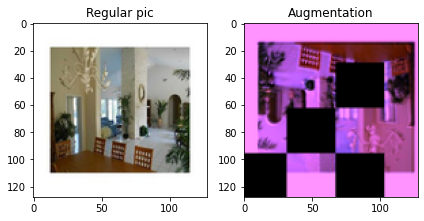

In [44]:
plt.subplot(1, 2, 1)
plt.imshow(data_x_norm[42])
plt.title('Regular pic')
plt.subplot(1, 2, 2)
plt.imshow(data_x[42])
plt.title('Augmentation')
plt.tight_layout()

In [56]:
generator(data_x ,y, 32)

<generator object generator at 0x7ff69c843d50>

- some preview

In [45]:
print(Counter(data_y))

Counter({'Livingroom': 1273, 'Bedroom': 1248, 'Dinning': 1158, 'Kitchen': 965, 'Bathroom': 606})


In [46]:
classes_list = list(Counter(data_y).keys())

- i'll have to deal with this unbalanced classes later. 
- let's begin with the simplest stuff first

In [47]:
print("pics shape: ",data_x.shape,
      "\nnumber of classes: ", len(set(data_y))
      )

pics shape:  (5250, 128, 128, 3) 
number of classes:  5


Dinning


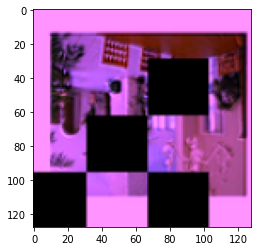

In [48]:
# # showing some stuff 
print(data_y[42])
imgplot = plt.imshow(data_x[42])
plt.show()

- transforming y-label into numeric

In [49]:
# transforming labels into numeric
y = np.unique(data_y)
mapping = { key : value for key,value in zip(y,range(len(y)))}
data_y_num = np.array([mapping[i] for i in data_y])

In [62]:
# transforming labels into numeric
y = np.unique(data_y)
mapping = { key : value for key,value in zip(y,range(len(y)))}
data_y_num = np.array([mapping[i] for i in data_y])

test_size_1st_split = 0.2
test_size_2nd_split= 0.5

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y_num, test_size=test_size_1st_split)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_size_2nd_split) 
allx= len(data_x)
print(round(len(x_train)/allx,2), round(len(x_val)/allx,2), round(len(x_test)/allx,2))
del data_y
del data_x

#One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_val = lb.transform(y_val)

NameError: ignored

In [51]:
print("train:  ", x_train.shape, y_train.shape,
      "\ntest: ", x_test.shape,y_test.shape,
      "\nval:  ", x_val.shape, y_val.shape)

train:   (3675, 128, 128, 3) (3675, 5) 
test:  (788, 128, 128, 3) (788, 5) 
val:   (787, 128, 128, 3) (787, 5)


In [52]:
#x_train[0]

In [ ]:
# #Data Augmentation first
# # antes sólo rotation_angle=2, horizontal_flip=True, zoom_range=.1
# train_generator = ImageDataGenerator(rotation_range=2, shear_range=0.2, vertical_flip=True, horizontal_flip=True, zoom_range=.1)
# val_generator = ImageDataGenerator(rotation_range=2, shear_range=0.2, vertical_flip=True, horizontal_flip=True, zoom_range=.1)
# test_generator = ImageDataGenerator(rotation_range=2, shear_range=0.2, vertical_flip=True, horizontal_flip= True, zoom_range=.1)

# #Fitting the augmentation defined above to the data
# train_generator.fit(x_train)
# val_generator.fit(x_val)
# test_generator.fit(x_test)

# entrenar todos los modelos  con una misma configuración

In [ ]:
#Initializing the hyperparameters
batch_size= 128
epochs=200
#sgd=SGD(learning_rate=.01,momentum=.9,nesterov=False)
#sgd=Adam(learning_rate=.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
loss_type='categorical_crossentropy'

In [ ]:
from tensorflow.keras.applications import Xception, InceptionResNetV2, DenseNet121

In [ ]:
pre_trained_vgg16 = vgg16_19_conf("vgg16",5, True, 0.2, y_train)
pre_trained_vgg19 = vgg16_19_conf("vgg16",5, True, 0.2, y_train)
pre_trained_resnet50 = resnet50_conf(5, True, 0.2, y_train)

pre_trained_xception= generic_last_2layers(
    Xception(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax'),
    5, False, 0.2, y_train)

pre_trained_xception_drop= generic_last_2layers(
    Xception(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax'),
    5, True, 0.2, y_train)

pre_trained_inception= generic_last_2layers(
    InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax'),
    5, False, 0.2, y_train)

pre_trained_inception_drop= generic_last_2layers(
    InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax'),
    5, True, 0.2, y_train
    )
# pre_trained_densenet= generic_last_2layers(
#     DenseNet121(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax'),
#     5, False, 0.2, y_train
#     )
# pre_trained_densenet_drop= generic_last_2layers(
#     DenseNet121(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax'),
#     5, True, 0.2, y_train
#     )

models = [#pre_trained_vgg16, 
          #pre_trained_vgg19, 
          #pre_trained_resnet50,
          pre_trained_xception,
          pre_trained_xception_drop,
          pre_trained_inception,
          pre_trained_inception_drop,
          ]

def naming_model(model):
  '''gives a name to save it after training'''
  if model== pre_trained_vgg16:
    name = "vgg16-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
  elif model == pre_trained_vgg19:
    name = "vgg19-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
  elif model == pre_trained_resnet50:
    name = "resnet50-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')   
  elif model == pre_trained_xception:
    name = "xception-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')   
  elif model == pre_trained_xception_drop:
    name = "xception_drop-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')   
  elif model == pre_trained_inception:
    name = "InceptionResNetV2-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')   
  elif model == pre_trained_inception_drop:
    name = "InceptionResNetV2_drop-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')   
  return name

219070464/219055592 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/200
28/28 - 55s - loss: 1.4446 - accuracy: 0.3685 - val_loss: 1.2334 - val_accuracy: 0.5169 - 55s/epoch - 2s/step
Epoch 2/200
28/28 - 21s - loss: 1.2036 - accuracy: 0.5100 - val_loss: 1.1637 - val_accuracy: 0.5208 - 21s/epoch - 732ms/step
Epoch 3/200
28/28 - 21s - loss: 1.1398 - accuracy: 0.5413 - val_loss: 1.1257 - val_accuracy: 0.5612 - 21s/epoch - 733ms/step
Epoch 4/200
28/28 - 20s - loss: 1.1208 - accuracy: 0.5464 - val_loss: 1.1350 - val_accuracy: 0.5234 - 20s/epoch - 727ms/step
Epoch 5/200
28/28 - 21s - loss: 1.0724 - accuracy: 0.5830 - val_loss: 1.1073 - val_accuracy: 0.5365 - 21s/epoch - 738ms/step
Epoch 6/200
28/28 - 21s - loss: 1.0451 - accuracy: 0.5791 - val_loss: 1.0983 - val_accuracy: 0.5573 - 21s/epoch - 740ms/step
Epoch 7/200
28/28 - 21s - loss: 1.0247 - accuracy: 0.5997 - val_loss: 1.0964 - val_accuracy: 0.5742 - 21s/epoch - 741ms/step
Epoch 8/200
28/28 - 21s - loss: 1.0031 - accuracy: 0.6092 - val_loss: 1.0962 - val_accuracy: 0.5482 - 21s/epoch - 741ms/step
Epo

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


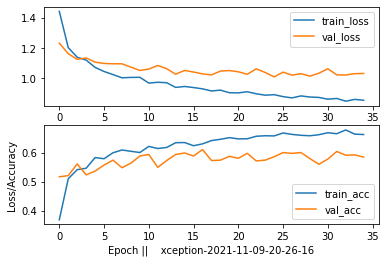

[INFO]: Model godness...
epochs:  35 
               precision    recall  f1-score   support

     Dinning       0.76      0.74      0.75        85
     Bedroom       0.77      0.70      0.73       195
  Livingroom       0.69      0.70      0.69       175
     Kitchen       0.66      0.63      0.64       150
    Bathroom       0.51      0.56      0.53       183

    accuracy                           0.66       788
   macro avg       0.67      0.67      0.67       788
weighted avg       0.67      0.66      0.66       788



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/200
28/28 - 25s - loss: 1.4588 - accuracy: 0.3566 - val_loss: 1.2465 - val_accuracy: 0.4896 - 25s/epoch - 903ms/step
Epoch 2/200
28/28 - 20s - loss: 1.2562 - accuracy: 0.4674 - val_loss: 1.1689 - val_accuracy: 0.5339 - 20s/epoch - 730ms/step
Epoch 3/200
28/28 - 20s - loss: 1.1678 - accuracy: 0.5125 - val_loss: 1.1216 - val_accuracy: 0.5573 - 20s/epoch - 730ms/step
Epoch 4/200
28/28 - 20s - loss: 1.1377 - accuracy: 0.5340 - val_loss: 1.1121 - val_accuracy: 0.5690 - 20s/epoch - 730ms/step
Epoch 5/200
28/28 - 20s - loss: 1.1023 - accuracy: 0.5565 - val_loss: 1.1195 - val_accuracy: 0.5534 - 20s/epoch - 726ms/step
Epoch 6/200
28/28 - 20s - loss: 1.0752 - accuracy: 0.5723 - val_loss: 1.0827 - val_accuracy: 0.5521 - 20s/epoch - 731ms/step
Epoch 7/200
28/28 - 20s - loss: 1.0664 - accuracy: 0.5768 - val_loss: 1.0950 - val_accuracy: 0.5521 - 20s/epoch - 727ms/step
Epoch 8/200
28/28 - 20s - loss: 1.0566 - accuracy: 0.5771 - val_loss: 1.0621 - val_accuracy: 0.5534 - 20s/epoch - 728ms/step


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


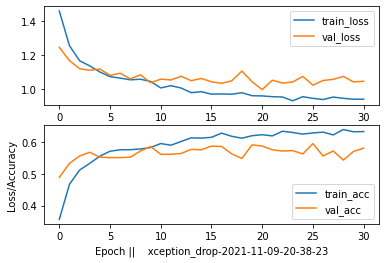

[INFO]: Model godness...
epochs:  31 
               precision    recall  f1-score   support

     Dinning       0.72      0.74      0.73        85
     Bedroom       0.68      0.76      0.72       195
  Livingroom       0.63      0.70      0.66       175
     Kitchen       0.72      0.63      0.67       150
    Bathroom       0.56      0.48      0.52       183

    accuracy                           0.65       788
   macro avg       0.66      0.66      0.66       788
weighted avg       0.65      0.65      0.65       788



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/200
28/28 - 42s - loss: 1.6408 - accuracy: 0.3451 - val_loss: 1.3076 - val_accuracy: 0.4740 - 42s/epoch - 1s/step
Epoch 2/200
28/28 - 22s - loss: 1.2928 - accuracy: 0.4790 - val_loss: 1.2203 - val_accuracy: 0.5117 - 22s/epoch - 772ms/step
Epoch 3/200
28/28 - 22s - loss: 1.1860 - accuracy: 0.5151 - val_loss: 1.1672 - val_accuracy: 0.5143 - 22s/epoch - 773ms/step
Epoch 4/200
28/28 - 22s - loss: 1.1397 - accuracy: 0.5312 - val_loss: 1.1238 - val_accuracy: 0.5456 - 22s/epoch - 769ms/step
Epoch 5/200
28/28 - 22s - loss: 1.0865 - accuracy: 0.5658 - val_loss: 1.0982 - val_accuracy: 0.5495 - 22s/epoch - 771ms/step
Epoch 6/200
28/28 - 21s - loss: 1.0711 - accuracy: 0.5757 - val_loss: 1.1083 - val_accuracy: 0.5456 - 21s/epoch - 766ms/step
Epoch 7/200
28/28 - 22s - loss: 1.0534 - accuracy: 0.5853 - val_loss: 1.0964 - val_accuracy: 0.5690 - 22s/epoch - 778ms/step
Epoch 8/200
28/28 - 21s - loss: 1.0516 - accuracy: 0.5805 - val_loss: 1.0839 - val_accuracy: 0.5807 - 21s/epoch - 765ms/step
Epo

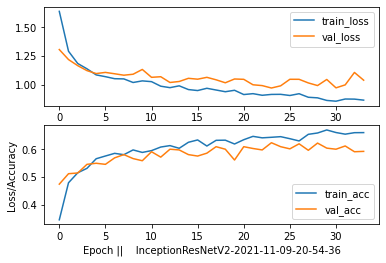

[INFO]: Model godness...
epochs:  34 
               precision    recall  f1-score   support

     Dinning       0.73      0.69      0.71        85
     Bedroom       0.76      0.70      0.73       195
  Livingroom       0.61      0.73      0.66       175
     Kitchen       0.67      0.57      0.62       150
    Bathroom       0.54      0.57      0.56       183

    accuracy                           0.65       788
   macro avg       0.66      0.65      0.65       788
weighted avg       0.66      0.65      0.65       788



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/200
28/28 - 40s - loss: 1.8770 - accuracy: 0.3307 - val_loss: 1.3420 - val_accuracy: 0.4557 - 40s/epoch - 1s/step
Epoch 2/200
28/28 - 22s - loss: 1.4822 - accuracy: 0.4205 - val_loss: 1.1894 - val_accuracy: 0.5365 - 22s/epoch - 793ms/step
Epoch 3/200
28/28 - 22s - loss: 1.3663 - accuracy: 0.4635 - val_loss: 1.1355 - val_accuracy: 0.5469 - 22s/epoch - 787ms/step
Epoch 4/200
28/28 - 22s - loss: 1.2955 - accuracy: 0.4849 - val_loss: 1.1276 - val_accuracy: 0.5651 - 22s/epoch - 787ms/step
Epoch 5/200
28/28 - 22s - loss: 1.2390 - accuracy: 0.5131 - val_loss: 1.0955 - val_accuracy: 0.5833 - 22s/epoch - 790ms/step
Epoch 6/200
28/28 - 22s - loss: 1.1769 - accuracy: 0.5264 - val_loss: 1.0770 - val_accuracy: 0.5729 - 22s/epoch - 785ms/step
Epoch 7/200
28/28 - 22s - loss: 1.2031 - accuracy: 0.5334 - val_loss: 1.1017 - val_accuracy: 0.5846 - 22s/epoch - 774ms/step
Epoch 8/200
28/28 - 22s - loss: 1.1806 - accuracy: 0.5421 - val_loss: 1.1181 - val_accuracy: 0.5508 - 22s/epoch - 769ms/step
Epo

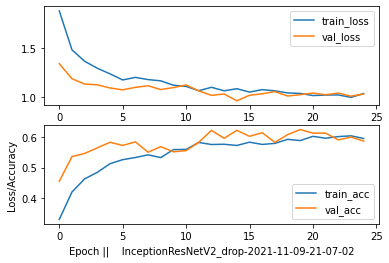

[INFO]: Model godness...
epochs:  25 
               precision    recall  f1-score   support

     Dinning       0.76      0.72      0.74        85
     Bedroom       0.71      0.76      0.74       195
  Livingroom       0.63      0.70      0.67       175
     Kitchen       0.61      0.63      0.62       150
    Bathroom       0.58      0.48      0.52       183

    accuracy                           0.65       788
   macro avg       0.66      0.66      0.66       788
weighted avg       0.65      0.65      0.65       788



In [ ]:
monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,patience=10,mode='auto',verbose=1, restore_best_weights=True)
#monitor= ReduceLROnPlateau(monitor='accuracy', factor=.001, patience=3, min_lr=1e-4) # "val_acc " warning

for model in models:
  
  model.compile(optimizer = "adam", loss=loss_type ,metrics=['accuracy'])
  model_result= model.fit_generator(
    generator(data_x ,y, batch_size), # <<========================== aquíiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii
    epochs = epochs, 
    validation_data = val_generator.flow(x_val, y_val, batch_size = batch_size), 
    steps_per_epoch = len(x_train)//batch_size , # to avoid running out of data error
    validation_steps  = len(x_test)//batch_size, # to avoid running out of data error
    callbacks=[monitor], 
    verbose = 2
    )
  
  number_of_epochs_it_ran = len(model_result.history['loss']) 
  name = naming_model(model)
  model.save(output_folder+name+".h5")

  plotting_model(model_result,number_of_epochs_it_ran, name)

  #Evaluatin
  print("[INFO]: Model godness...")
  y_pred = model.predict(x_test, batch_size=128)
  y_true=np.argmax(y_test,axis=1)
  print("epochs: ", number_of_epochs_it_ran, "\n",
      classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names = classes_list )
      )

In [ ]:
asdfasdfasd

NameError: ignored